In [41]:
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize


In [42]:
annotation_file = os.path.join('dataset/train/_annotations.coco.json')
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


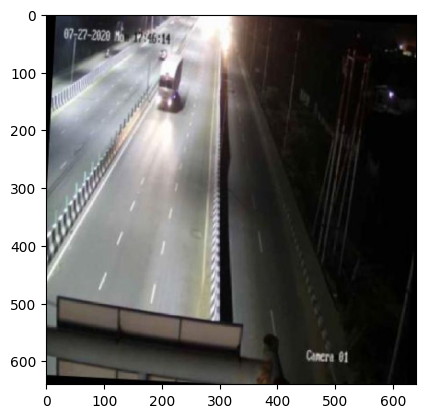

In [43]:
image_ids = coco.getImgIds()
image_info = coco.loadImgs(image_ids[0])[0]
image_path = os.path.join('dataset/train', image_info['file_name'])

image = imread(image_path)
plt.imshow(image)
plt.show()

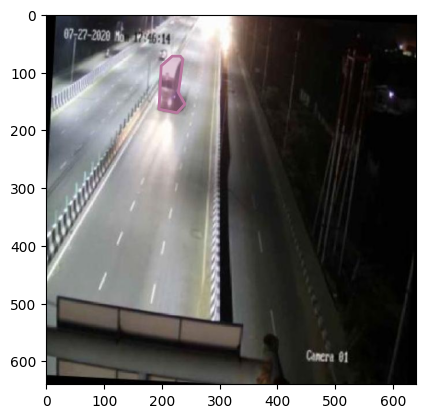

In [44]:
ann_ids = coco.getAnnIds(imgIds=image_info['id'])
anns = coco.loadAnns(ann_ids)

plt.imshow(image)
coco.showAnns(anns)
plt.show()

In [61]:
train_image_dir = os.path.join('dataset/train')
train_mask_dir = os.path.join('dataset/train/masks')
valid_image_dir = os.path.join('dataset/valid')
valid_mask_dir = os.path.join('dataset/valid/masks')
test_image_dir = os.path.join('dataset/test')
test_mask_dir = os.path.join('dataset/test/masks')

In [62]:
def load_image(image_path, mask_path, img_size=(150, 150)):
    image = imread(image_path)
    if os.path.exists(mask_path):
        mask = imread(mask_path, as_gray=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        mask = np.expand_dims(mask, axis=-1) / 255.0
    else:
        mask = np.zeros((*img_size, 1))
    
    image = resize(image, img_size, mode='constant', preserve_range=True) / 255.0
    
    return image, mask

In [63]:
def load_data(image_dir, mask_dir, img_size=(150, 150)):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    mask_files = [f.replace('.jpg', '.png') for f in image_files]
    
    images = []
    masks = []
    
    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        
        image, mask = load_image(image_path, mask_path, img_size)
        images.append(image)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [64]:
X_train, y_train = load_data(train_image_dir, train_mask_dir)
X_valid, y_valid = load_data(valid_image_dir, valid_mask_dir)
X_test, y_test = load_data(test_image_dir, test_mask_dir)

print(f'Train images: {X_train.shape}, Train masks: {y_train.shape}')
print(f'Validation images: {X_valid.shape}, Validation masks: {y_valid.shape}')
print(f'Validation images: {X_test.shape}, Validation masks: {y_test.shape}')

Train images: (1601, 150, 150, 3), Train masks: (1601, 150, 150, 1)
Validation images: (300, 150, 150, 3), Validation masks: (300, 150, 150, 1)
Validation images: (100, 150, 150, 3), Validation masks: (100, 150, 150, 1)


In [52]:
def unet_model(input_size=(150, 150, 3)):
    inputs = tf.keras.Input(input_size)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    # Decoder
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(p1)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c6)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [53]:
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 150, 150, 64)   │        16,448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 150, 150, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,089 (504.25 KB)

 Trainable params: 129,089 (504.25 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).repeat()

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
valid_dataset = valid_dataset.batch(32).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(32).repeat()


In [58]:
train_steps = len(X_train) // 32
valid_steps = len(X_valid) // 32

In [59]:
unet.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.9902 - loss: 0.1668 - val_accuracy: 0.9908 - val_loss: 0.0039
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9910 - loss: 0.0031 - val_accuracy: 0.9911 - val_loss: 7.0200e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9911 - loss: 4.5455e-04 - val_accuracy: 0.9918 - val_loss: 2.2794e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9899 - loss: 2.9112e-04 - val_accuracy: 0.9909 - val_loss: 2.4330e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9904 - loss: 2.6760e-04 - val_accuracy: 0.9920 - val_loss: 2.0733e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9903 - loss: 2.6103e-04 - val_accuracy: 0.9911 - val_loss: 2.7351e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.9904 - loss: 2.7833e-04 - val_accuracy: 0.9905 - val_loss: 2.4881e-04
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.99

In [66]:
test_loss, test_acc = unet.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

  18817/Unknown 9671s 514ms/step - accuracy: 0.9872 - loss: 3.5045e-04